# Reliance Stock Prediction

### dependent variable = Close Price

### 1. Import required packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import statsmodels.api as sm

from statsmodels.tsa.stattools import acf, pacf
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset

### Read the data from the Source

In [2]:
stock_data = pd.read_csv('reliance_stock_data_(1990-2023).csv')
stock_data

,Date,Price,Open,High,Low,Volume,Change%
0,Jan 02 1990,7.27,7.31,7.44,7.14,0,-1.62%
1,Jan 03 1990,6.92,7.18,7.18,6.84,0,-4.81%
2,Jan 04 1990,6.50,6.24,6.58,6.24,0,-6.07%
3,Jan 05 1990,6.71,6.37,6.71,6.37,0,3.23%
4,Jan 08 1990,6.71,7.05,7.05,6.67,0,0.00%
...,...,...,...,...,...,...,...
8175,Dec 11 2023,2459.05,2452.15,2467.40,2452.15,169.52K,+0.12%
8176,Dec 12 2023,2423.95,2458.00,2464.90,2420.25,98.11K,-1.43%
8177,Dec 13 2023,2433.40,2427.75,2438.00,2406.30,137.30K,+0.39%
8178,Dec 14 2023,2464.50,2453.00,2475.00,2442.70,3.65M,+1.28%


In [3]:
stock_data.isnull().sum()

Date        0
 Price      0
 Open       0
 High       0
 Low        0
 Volume     0
 Change%    0
dtype: int64

In [4]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8180 entries, 0 to 8179
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      8180 non-null   object 
 1    Price    8180 non-null   float64
 2    Open     8180 non-null   float64
 3    High     8180 non-null   float64
 4    Low      8180 non-null   float64
 5    Volume   8180 non-null   object 
 6    Change%  8180 non-null   object 
dtypes: float64(4), object(3)
memory usage: 447.5+ KB


In [5]:
# Assuming stock_data is your DataFrame
stock_data.set_index(pd.to_datetime(stock_data['Date']), inplace=True)  # Set 'Date' as index
stock_data.drop(columns=['Date'], inplace=True)  # Drop the 'Date' column

In [6]:
stock_data.columns

Index([' Price', ' Open', ' High', ' Low', ' Volume', ' Change%'], dtype='object')

In [7]:
stock_data = stock_data.rename(columns={' Price':'Price',' Open': 'Open', ' High': 'High', ' Low': 'Low', ' Volume':'Volume',' Change%':'Change%'})

In [8]:
stock_data = stock_data.drop(['Open','High','Low','Volume','Change%'], axis=1)
stock_data

,Price
Date,
1990-01-02,7.27
1990-01-03,6.92
1990-01-04,6.50
1990-01-05,6.71
1990-01-08,6.71
...,...
2023-12-11,2459.05
2023-12-12,2423.95
2023-12-13,2433.40


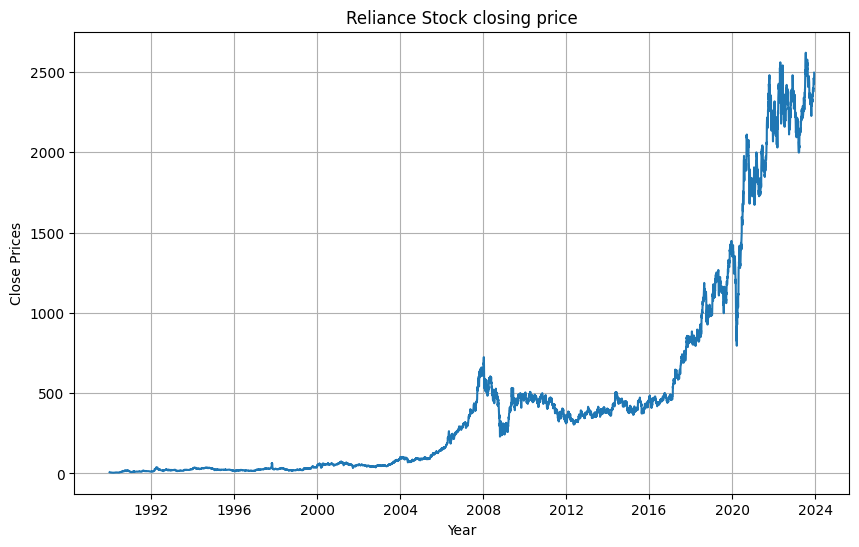

In [9]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Close Prices')
plt.plot(stock_data['Price'])
plt.title('Reliance Stock closing price')
plt.show()

<Axes: >

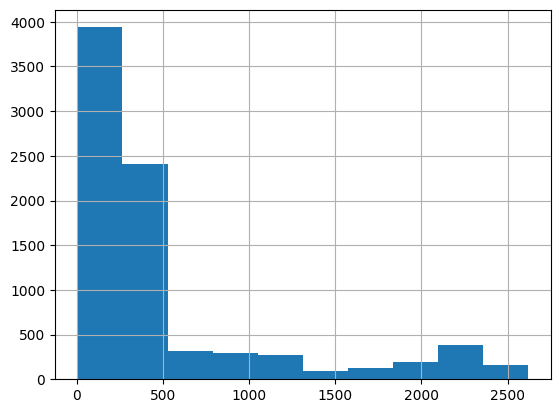

In [10]:
stock_data['Price'].hist()

<Axes: ylabel='Density'>

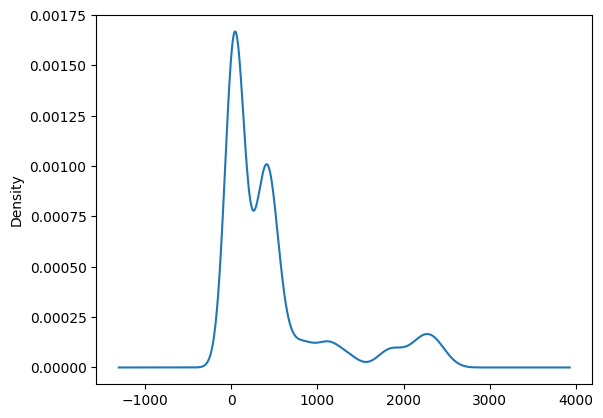

In [11]:
#Distribution of the dataset
df_close = stock_data['Price']
df_close.plot(kind='kde')

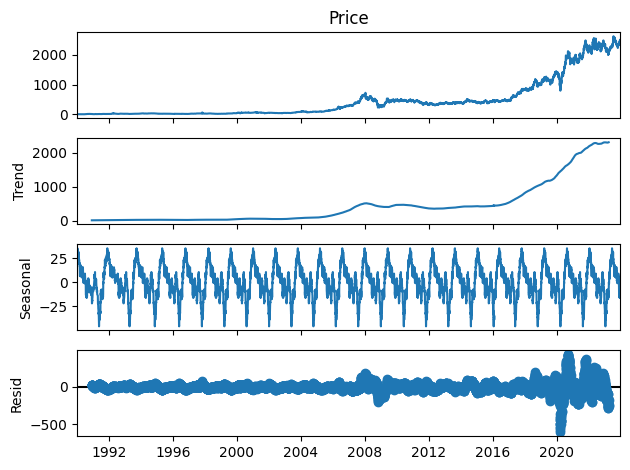

In [12]:
dec=seasonal_decompose(stock_data.Price,period=350)
dec.plot()
plt.show()

In [13]:
stock_data['Price'].describe()

count    8180.000000
mean      483.773132
std       651.354380
min         4.360000
25%        33.980000
50%       307.170000
75%       483.885000
max      2619.850000
Name: Price, dtype: float64

In [14]:
X = stock_data.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=62.403694, mean2=905.142570
variance1=5352.210775, variance2=487964.708788


# Augmented Dickey fuller test.

In [15]:
def TestStationaryPlot(stock_data):
    rol_mean = stock_data.rolling(window = 25, center = False).mean()
    rol_std = stock_data.rolling(window = 25, center = False).std()
    
    plt.plot(stock_data, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Closing Price', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

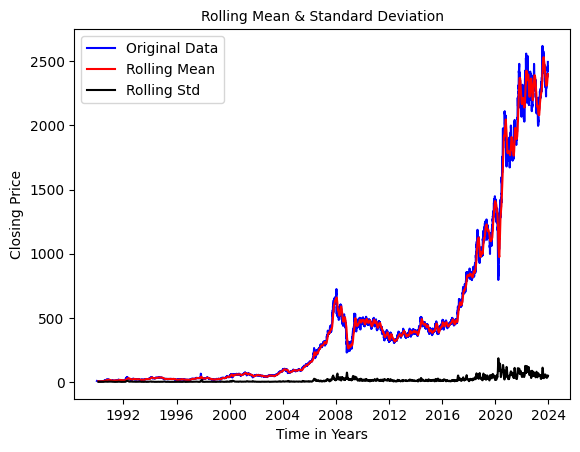

In [16]:
TestStationaryPlot(stock_data)

In [17]:
# null Hypothesis : Data is stationary
#alternate hypothesis : Data is not stationary
def TestStationaryAdfuller(stock_data, cutoff=0.01):
    stock_data_test = adfuller(stock_data, autolag='AIC')
    stock_data_test_output = pd.Series(stock_data_test[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])

    for key, value in stock_data_test[4].items():
        stock_data_test_output[f'Critical Value ({key})'] = value
    print(stock_data_test_output)

    if stock_data_test[1] <= cutoff:
        print("Failed to reject null hypothesis. Data is stationary")
    else:
        print("Failed to accept null hypothesis. Data is non-stationary")


In [18]:
TestStationaryAdfuller(stock_data)

Test Statistic                    1.778975
p-value                           0.998306
Lags Used                        37.000000
Number of Observations Used    8142.000000
Critical Value (1%)              -3.431153
Critical Value (5%)              -2.861895
Critical Value (10%)             -2.566959
dtype: float64
Failed to accept null hypothesis. Data is non-stationary


# Transforming Data into Stationary

# A) Moving Average Method

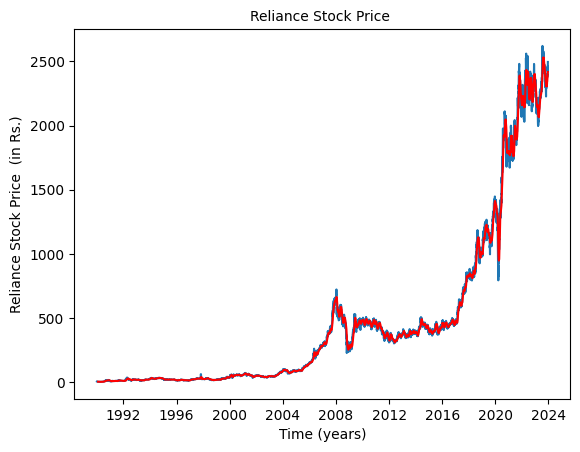

In [19]:
moving_avg = stock_data.rolling(20).mean()
plt.plot(stock_data)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('Reliance Stock Price  (in Rs.)', fontsize = 10)
plt.title('Reliance Stock Price ', fontsize = 10)
plt.show()

In [20]:
moving_avg_diff = stock_data - moving_avg
moving_avg_diff.head(15)

,Price
Date,
1990-01-02,NaN
1990-01-03,NaN
1990-01-04,NaN
1990-01-05,NaN
1990-01-08,NaN
1990-01-09,NaN
1990-01-10,NaN
1990-01-11,NaN
1990-01-15,NaN


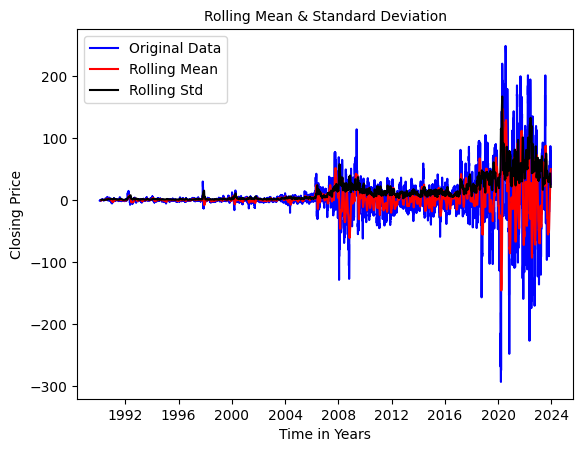

In [21]:
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff)

In [22]:
TestStationaryAdfuller(moving_avg_diff)

Test Statistic                -1.310076e+01
p-value                        1.711885e-24
Lags Used                      3.700000e+01
Number of Observations Used    8.123000e+03
Critical Value (1%)           -3.431155e+00
Critical Value (5%)           -2.861896e+00
Critical Value (10%)          -2.566959e+00
dtype: float64
Failed to reject null hypothesis. Data is stationary


## First Order Differencing

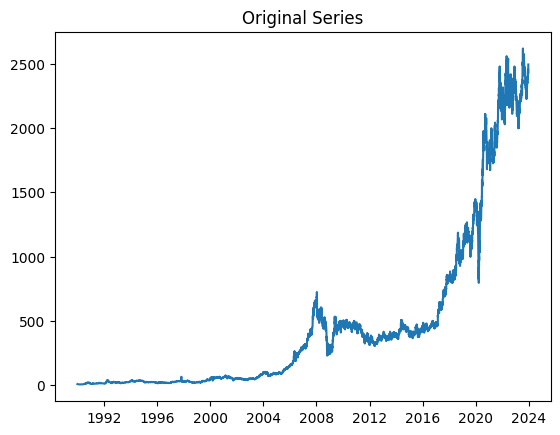

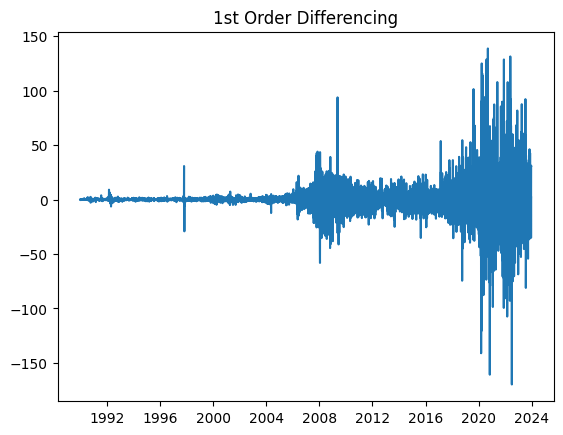

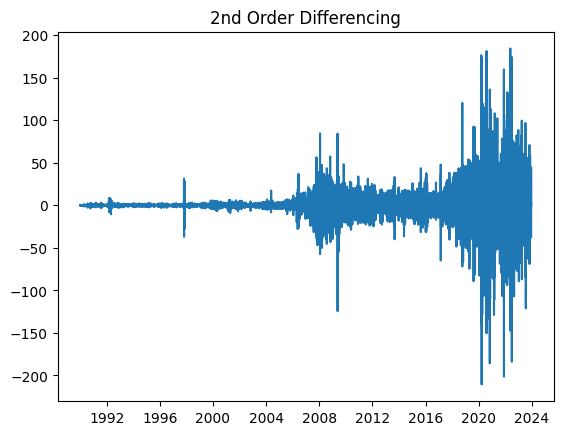

In [23]:
# Assuming 'stock_data' is your pandas Series/DataFrame containing the stock data

# Original Series
plt.plot(stock_data)
plt.title('Original Series')
plt.show()

# 1st Differencing
stock_data_first_difference = stock_data.diff()
plt.plot(stock_data_first_difference)
plt.title('1st Order Differencing')
plt.show()

# 2nd Differencing
stock_data_second_difference = stock_data.diff().diff()
plt.plot(stock_data_second_difference)
plt.title('2nd Order Differencing')
plt.show()


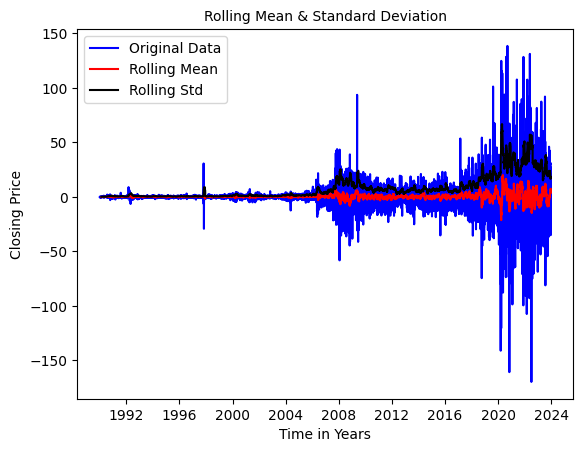

In [24]:
stock_data_first_difference = stock_data - stock_data.shift(1)  
TestStationaryPlot(stock_data_first_difference.dropna(inplace=False))

In [25]:
TestStationaryAdfuller(stock_data_first_difference.dropna(inplace=False))

Test Statistic                -1.639167e+01
p-value                        2.690456e-29
Lags Used                      3.600000e+01
Number of Observations Used    8.142000e+03
Critical Value (1%)           -3.431153e+00
Critical Value (5%)           -2.861895e+00
Critical Value (10%)          -2.566959e+00
dtype: float64
Failed to reject null hypothesis. Data is stationary


# Trend & Seasonality Plot

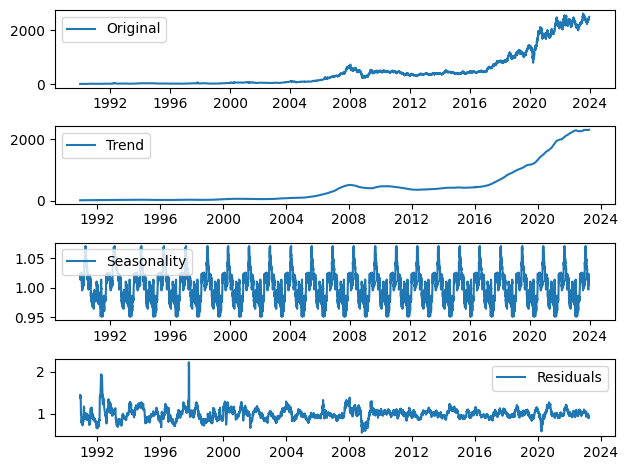

In [26]:
decomposition = seasonal_decompose(stock_data,period=350,model="multiplicable")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(stock_data, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### ACF & PACF Plots

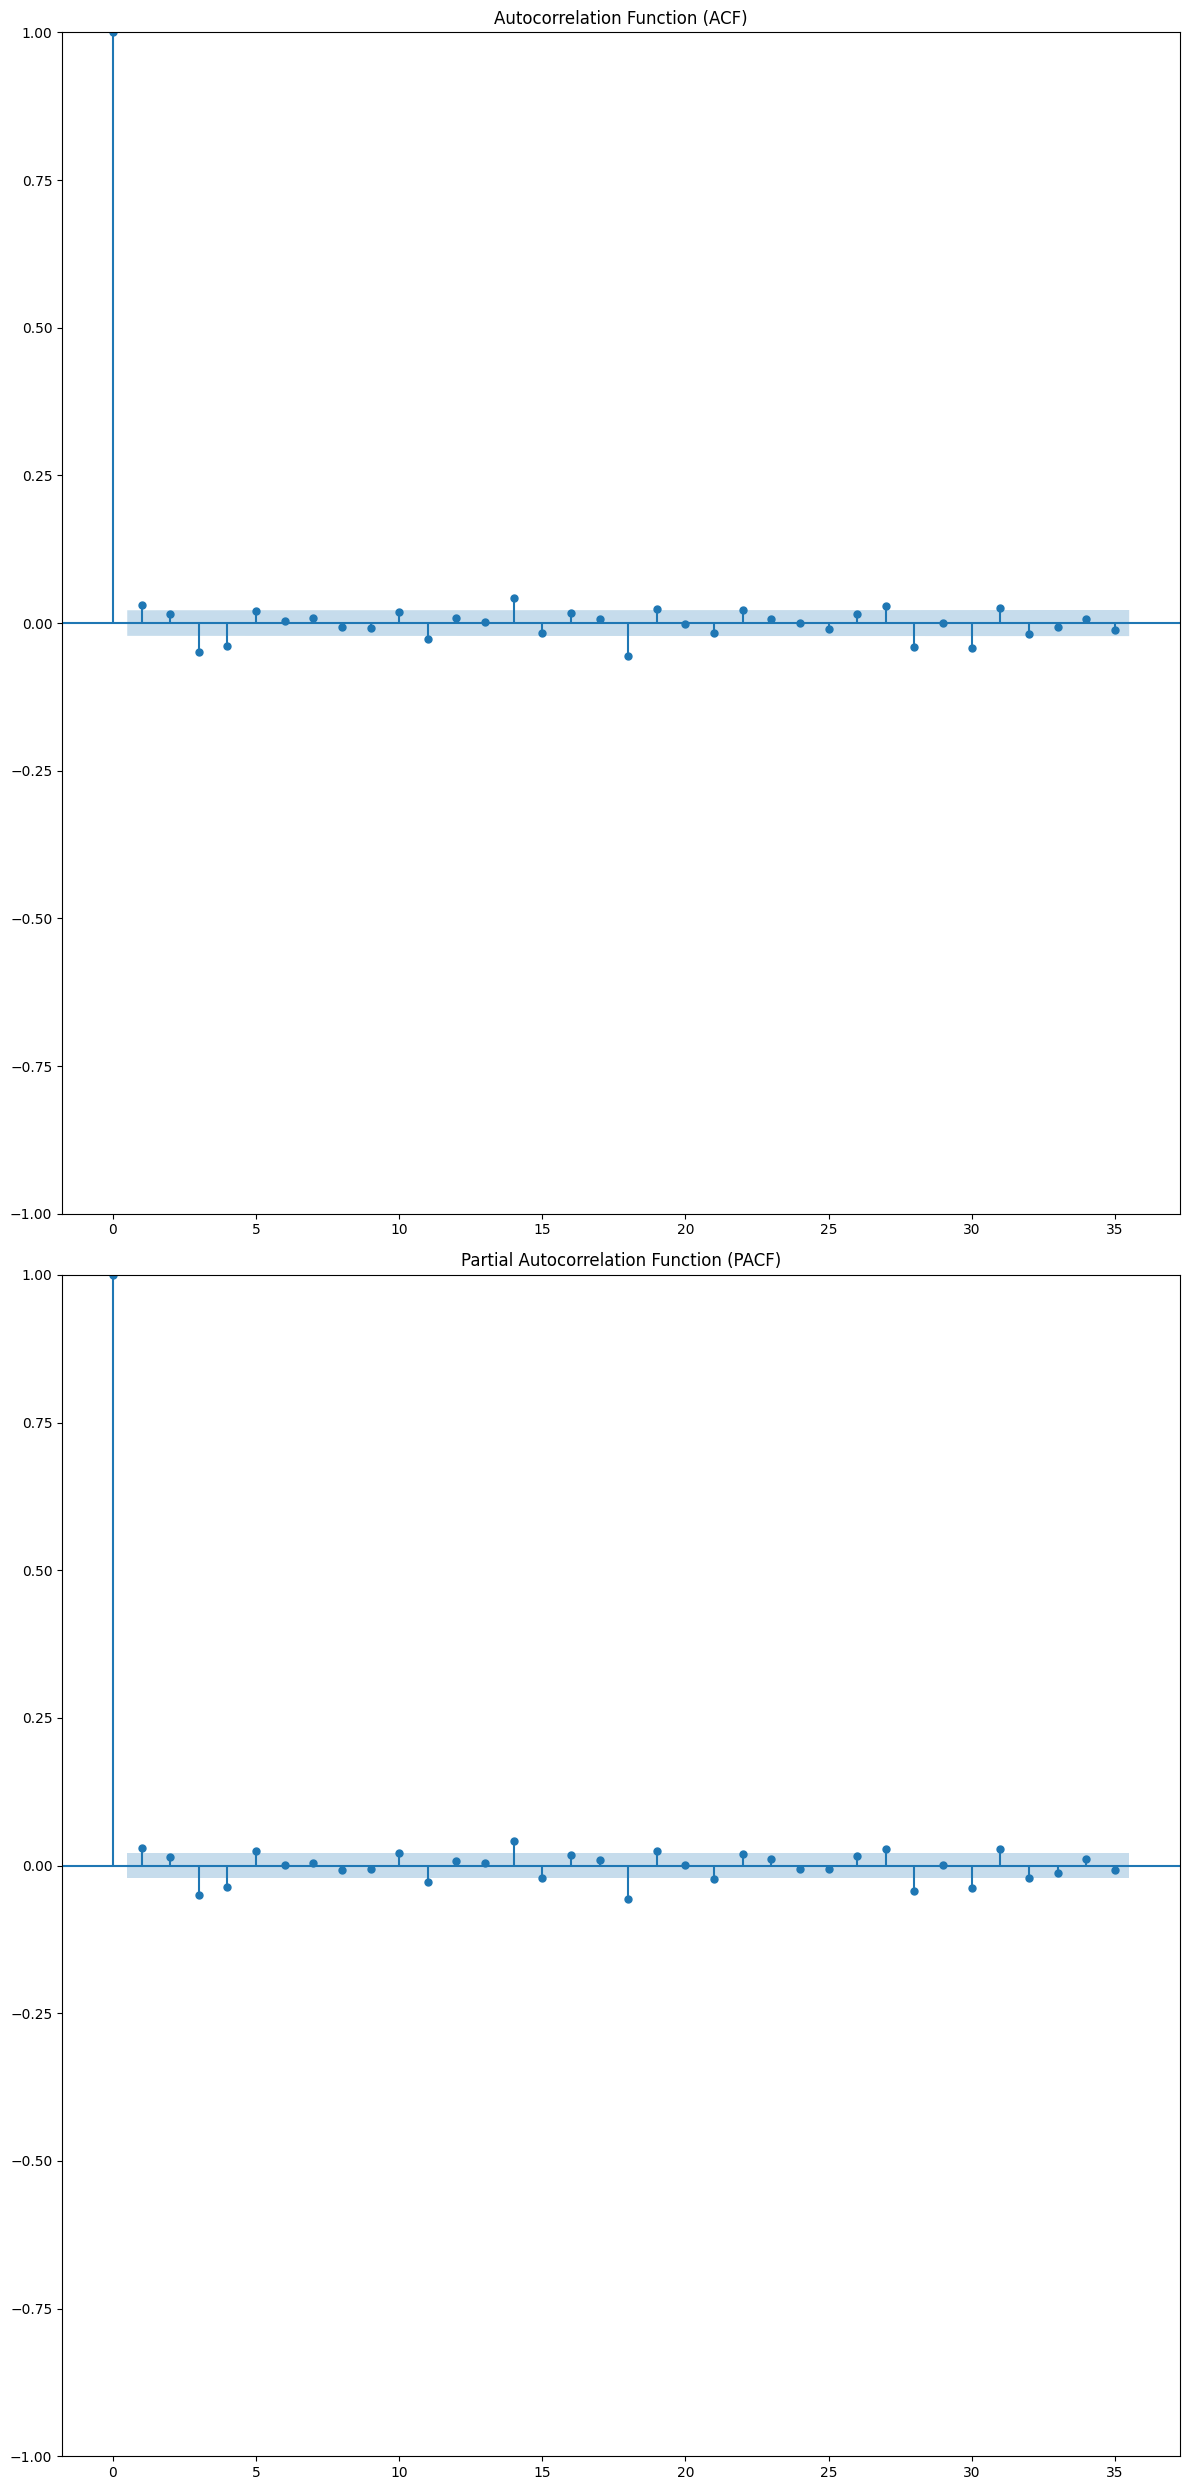

In [27]:
fig = plt.figure(figsize=(12, 25))  # Adjusting the figure size to fit both plots
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stock_data_first_difference.dropna(inplace=False), lags=35, ax=ax1)  # Change your_data_column to your actual data column
ax1.set_title('Autocorrelation Function (ACF)')

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stock_data_first_difference.dropna(inplace=False), lags=35, ax=ax2)  # Change your_data_column to your actual data column
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

## Data Partitioning

In [28]:
train_data = stock_data.iloc[:7689]
test_data = stock_data.iloc[7689:8180]
train_data

,Price
Date,
1990-01-02,7.27
1990-01-03,6.92
1990-01-04,6.50
1990-01-05,6.71
1990-01-08,6.71
...,...
2021-12-17,2124.80
2021-12-20,2067.51
2021-12-21,2098.29


In [29]:
test_data

,Price
Date,
2021-12-24,2154.17
2021-12-27,2151.85
2021-12-28,2177.41
2021-12-29,2181.13
2021-12-30,2141.73
...,...
2023-12-11,2459.05
2023-12-12,2423.95
2023-12-13,2433.40


### from First order Differencing we consider d=1 & from ACF & PACF plots we consider p=2,3,4 & q=1


## Various ARIMA MODELs

## ARIMA(2,1,1)

In [30]:
# Build Model
model_arima = ARIMA(train_data['Price'],order = (2,1,1))
model_arima = model_arima.fit()
model_arima.summary()

/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.l

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 7689
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -29728.972
Date:                Fri, 22 Dec 2023   AIC                          59465.944
Time:                        14:11:53   BIC                          59493.733
Sample:                             0   HQIC                         59475.475
                               - 7689                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3599      0.097     -3.705      0.000      -0.550      -0.170
ar.L2          0.0389      0.004     10.050      0.000       0.031       0.046
ma.L1          0.3757      0.097      3.872      0.000       0.186       0.566
sigma2       133.7513      0.521    256.844      0.000     132.731     134.772
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            360831.93
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             215.16   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
start = len(train_data)
end = len(train_data)+len(test_data)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

7689    2148.409438
7690    2147.983486
7691    2148.179496
7692    2148.092406
7693    2148.131364
           ...     
8175    2148.119335
8176    2148.119335
8177    2148.119335
8178    2148.119335
8179    2148.119335
Name: predicted_mean, Length: 491, dtype: float64


/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [72]:
end

8179

In [32]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 'rmse':rmse})

In [33]:
ns_arima_acc = forecast_accuracy(pred_arima.values, test_data.values)
ns_arima_acc

{'mape': 0.06742832440242495,
 'me': -148.03953274149487,
 'mae': 159.99229545367328,
 'rmse': 194.55492444291423}

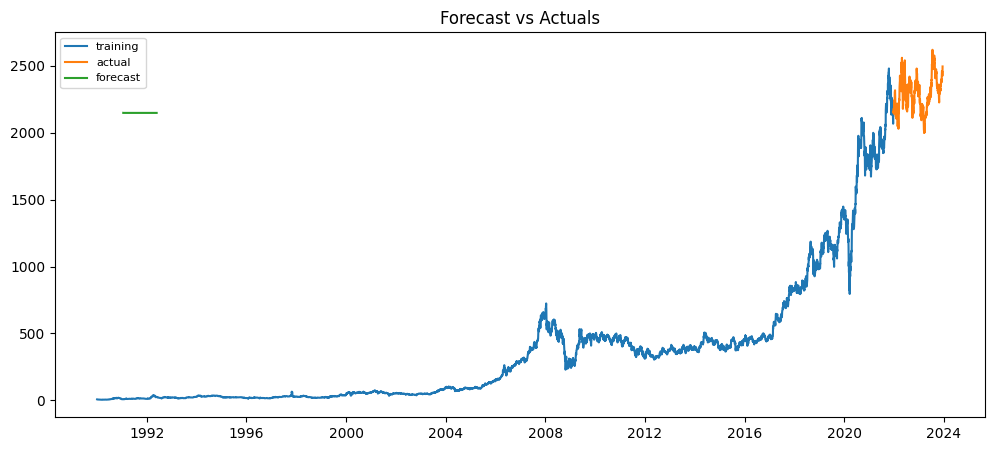

In [34]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(pred_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

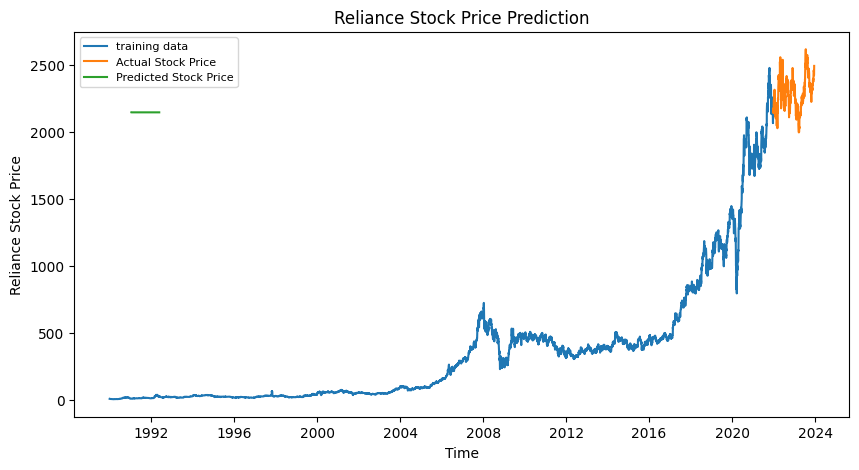

In [35]:
# Make a pandas series
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, label='Actual Stock Price')
plt.plot(pred_arima, label='Predicted Stock Price')
plt.title('Reliance Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Reliance Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# ARIMA(4,1,3)

In [36]:
Model_arima = ARIMA(train_data['Price'],order = (4,1,3))
Model_arima = Model_arima.fit()
Model_arima.summary()

/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.l

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 7689
Model:                 ARIMA(4, 1, 3)   Log Likelihood              -29719.388
Date:                Fri, 22 Dec 2023   AIC                          59454.776
Time:                        14:12:11   BIC                          59510.356
Sample:                             0   HQIC                         59473.838
                               - 7689                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9789      0.056    -17.541      0.000      -1.088      -0.870
ar.L2         -0.5532      0.070     -7.868      0.000      -0.691      -0.415
ar.L3         -0.5854      0.050    -11.759      0.000      -0.683      -0.488
ar.L4         -0.0343      0.005     -6.651      0.000      -0.044      -0.024
ma.L1          0.9951      0.056     17.781      0.000       0.885       1.105
ma.L2          0.5961      0.072      8.327      0.000       0.456       0.736
ma.L3          0.5788      0.051     11.262      0.000       0.478       0.680
sigma2       133.4266      0.514    259.573      0.000     132.419     134.434
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            364225.56
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             213.61   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
start = len(train_data)
end = len(train_data)+len(test_data)-1
Pred_arima = Model_arima.predict(start=start,end=end)
print(Pred_arima)

7689    2147.137278
7690    2141.548731
7691    2142.106014
7692    2144.779788
7693    2145.131857
           ...     
8175    2143.847775
8176    2143.847588
8177    2143.847772
8178    2143.847591
8179    2143.847769
Name: predicted_mean, Length: 491, dtype: float64


/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [38]:
Ns_arima_acc = forecast_accuracy(Pred_arima.values, test_data.values)
Ns_arima_acc

{'mape': 0.06877687429082328,
 'me': -152.31034533659053,
 'mae': 163.17710303272716,
 'rmse': 197.82417464575383}

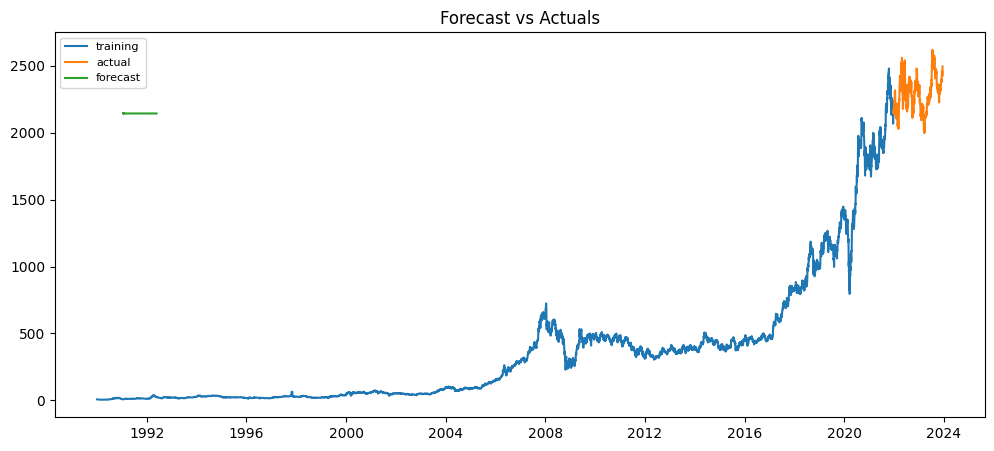

In [39]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(Pred_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Smoothing Technique Methods

In [40]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Simple Exponential Smoothing 

In [41]:
SES = SimpleExpSmoothing(train_data['Price']).fit(smoothing_level = 0.2)

/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [42]:
pred_ses = SES.predict(start = len(train_data),end = len(train_data)+len(test_data)-1)

/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [43]:
ns_ses_acc = forecast_accuracy(pred_ses.values,test_data.values)
ns_ses_acc

{'mape': 0.06876138467448754,
 'me': -152.26179599153045,
 'mae': 163.14055655961894,
 'rmse': 197.7866771832362}

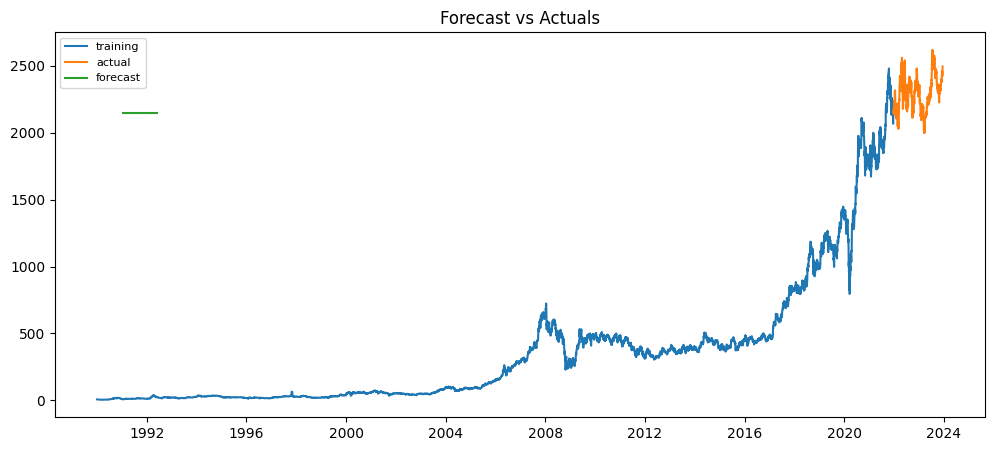

In [44]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(pred_ses, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Holt's Method

In [45]:
HLT= Holt(train_data["Price"]).fit(smoothing_level=0.8, smoothing_slope=0.2)

/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


In [46]:
pred_holt = HLT.predict(start = len(train_data),end = len(train_data)+len(test_data)-1)

/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [47]:
ns_hlt_acc = forecast_accuracy(pred_holt.values,test_data.values)
ns_hlt_acc

{'mape': 0.053725311372431285,
 'me': -6.084996983198009,
 'mae': 123.18861331737033,
 'rmse': 151.7580978786035}

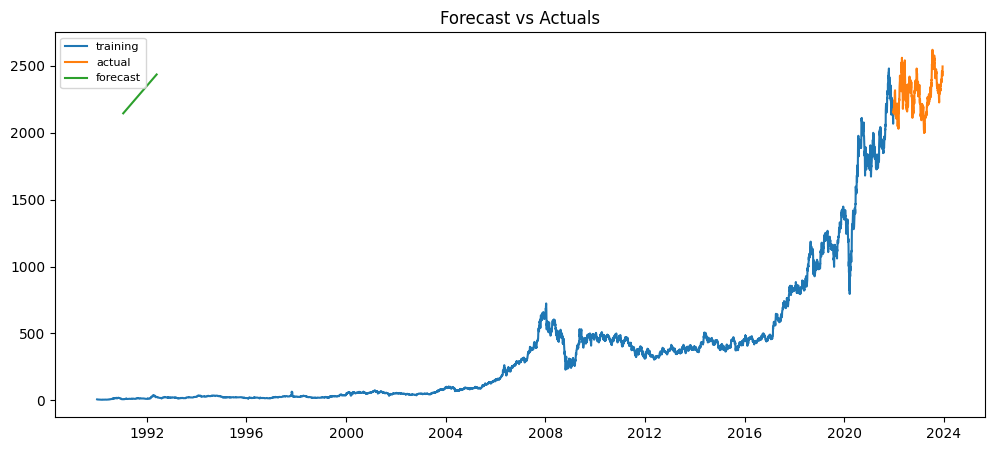

In [48]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(pred_holt, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Holt-Winter Method

In [49]:
HLW = ExponentialSmoothing(train_data['Price'],seasonal='add',trend='add',seasonal_periods=2).fit()

/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [50]:
pred_hlw=HLW.predict(start = len(train_data),end = len(train_data)+len(test_data)-1)

/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [51]:
ns_hlw_acc = forecast_accuracy(pred_hlw.values,test_data.values)
ns_hlw_acc

{'mape': 0.05246154840155115,
 'me': -71.61055680310592,
 'mae': 123.00938884568316,
 'rmse': 151.80967530366036}

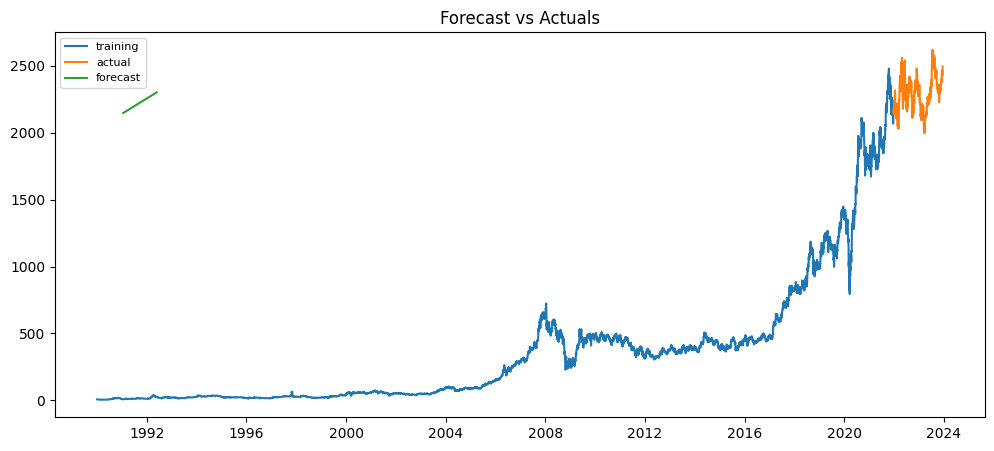

In [52]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(pred_hlw, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Modelwise Errors

### Model Sorted by the RMSE values

In [53]:
data = {"MODEL":pd.Series(["ARIMA(2,1,1)","ARIMA(4,1,3)","Simple exponential smoothing","Holt Method","Holt-Winter Method"]),
"RMSE_values":pd.Series([ns_arima_acc["rmse"],Ns_arima_acc["rmse"],ns_ses_acc["rmse"],ns_hlt_acc["rmse"],ns_hlw_acc["rmse"]]),
"MAPE_values":pd.Series([ns_arima_acc["mape"],Ns_arima_acc["mape"],ns_ses_acc["mape"],ns_hlt_acc["mape"],ns_hlw_acc["mape"]]),
"ME_values":pd.Series([ns_arima_acc["me"],Ns_arima_acc["me"],ns_ses_acc["me"],ns_hlt_acc["me"],ns_hlw_acc["me"]]),
"MAE_values":pd.Series([ns_arima_acc["mae"],Ns_arima_acc["mae"],ns_ses_acc["mae"],ns_hlt_acc["mae"],ns_hlw_acc["mae"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_values'])

,MODEL,RMSE_values,MAPE_values,ME_values,MAE_values
3,Holt Method,151.758098,0.053725,-6.084997,123.188613
4,Holt-Winter Method,151.809675,0.052462,-71.610557,123.009389
0,"ARIMA(2,1,1)",194.554924,0.067428,-148.039533,159.992295
2,Simple exponential smoothing,197.786677,0.068761,-152.261796,163.140557
1,"ARIMA(4,1,3)",197.824175,0.068777,-152.310345,163.177103


### Model Sorted by the MAPE values

In [54]:
tata = {"MODEL":pd.Series(["ARIMA(2,1,1)","ARIMA(4,1,3)","Simple exponential smoothing","Holt Method","Holt-Winter Method"]),
"RMSE_values":pd.Series([ns_arima_acc["rmse"],Ns_arima_acc["rmse"],ns_ses_acc["rmse"],ns_hlt_acc["rmse"],ns_hlw_acc["rmse"]]),
"MAPE_values":pd.Series([ns_arima_acc["mape"],Ns_arima_acc["mape"],ns_ses_acc["mape"],ns_hlt_acc["mape"],ns_hlw_acc["mape"]]),
"ME_values":pd.Series([ns_arima_acc["me"],Ns_arima_acc["me"],ns_ses_acc["me"],ns_hlt_acc["me"],ns_hlw_acc["me"]]),
"MAE_values":pd.Series([ns_arima_acc["mae"],Ns_arima_acc["mae"],ns_ses_acc["mae"],ns_hlt_acc["mae"],ns_hlw_acc["mae"]])}

table_mape=pd.DataFrame(tata)
table_mape.sort_values(['MAPE_values'])

,MODEL,RMSE_values,MAPE_values,ME_values,MAE_values
4,Holt-Winter Method,151.809675,0.052462,-71.610557,123.009389
3,Holt Method,151.758098,0.053725,-6.084997,123.188613
0,"ARIMA(2,1,1)",194.554924,0.067428,-148.039533,159.992295
2,Simple exponential smoothing,197.786677,0.068761,-152.261796,163.140557
1,"ARIMA(4,1,3)",197.824175,0.068777,-152.310345,163.177103


## Final Model

In [55]:
final_arima = ARIMA(stock_data['Price'],order = (2,1,1))
final_arima = final_arima.fit()
final_arima.summary()

/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.l

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 8180
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -33034.585
Date:                Fri, 22 Dec 2023   AIC                          66077.170
Time:                        14:12:17   BIC                          66105.207
Sample:                             0   HQIC                         66086.756
                               - 8180                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3416      0.154     -2.224      0.026      -0.643      -0.041
ar.L2          0.0344      0.005      6.627      0.000       0.024       0.045
ma.L1          0.3715      0.153      2.421      0.015       0.071       0.672
sigma2       188.6733      0.825    228.637      0.000     187.056     190.291
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            200252.32
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             317.65   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
final_arima.fittedvalues.tail(25)

Date
2023-11-10    2310.363244
2023-11-12    2313.623650
2023-11-13    2331.773012
2023-11-15    2314.049996
2023-11-16    2357.695803
2023-11-17    2364.711489
2023-11-20    2355.341657
2023-11-21    2349.035251
2023-11-22    2379.246148
2023-11-23    2388.753030
2023-11-24    2395.316520
2023-11-28    2394.467089
2023-11-29    2394.466176
2023-11-30    2400.717613
2023-12-01    2375.803205
2023-12-04    2393.353026
2023-12-05    2422.445715
2023-12-06    2438.454631
2023-12-07    2461.624856
2023-12-08    2457.959467
2023-12-11    2455.918032
2023-12-12    2459.191839
2023-12-13    2422.945953
2023-12-14    2432.849018
2023-12-15    2465.959280
dtype: float64

In [57]:
stock_data.tail(25)

,Price
Date,
2023-11-10,2314.30
2023-11-12,2330.90
2023-11-13,2314.30
2023-11-15,2356.90
2023-11-16,2363.35
2023-11-17,2355.85
2023-11-20,2349.30
2023-11-21,2378.50
2023-11-22,2387.75


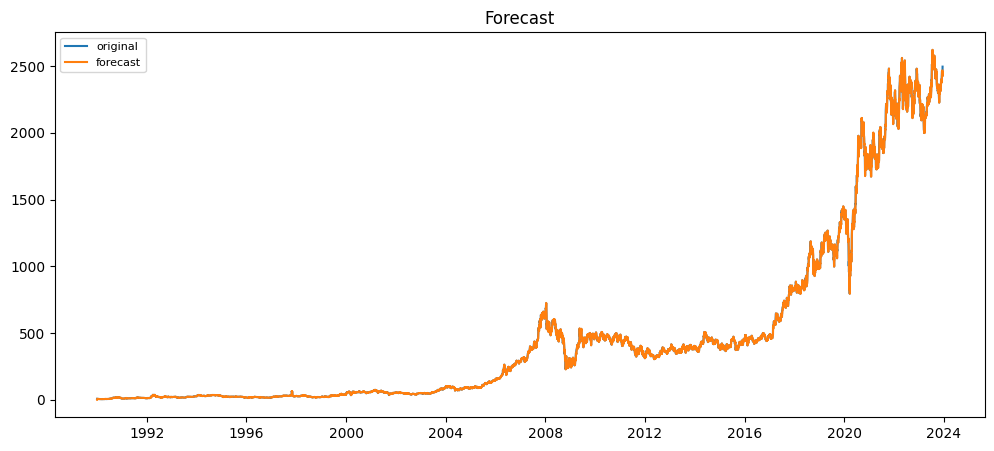

In [58]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(stock_data, label='original')
plt.title('Original')

plt.plot(final_arima.fittedvalues, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [59]:
final_arima.forecast(steps=40)

/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


8180    2496.644634
8181    2497.206371
8182    2497.064116
8183    2497.132025
8184    2497.103934
8185    2497.115866
8186    2497.110824
8187    2497.112957
8188    2497.112055
8189    2497.112436
8190    2497.112275
8191    2497.112343
8192    2497.112314
8193    2497.112326
8194    2497.112321
8195    2497.112323
8196    2497.112322
8197    2497.112323
8198    2497.112323
8199    2497.112323
8200    2497.112323
8201    2497.112323
8202    2497.112323
8203    2497.112323
8204    2497.112323
8205    2497.112323
8206    2497.112323
8207    2497.112323
8208    2497.112323
8209    2497.112323
8210    2497.112323
8211    2497.112323
8212    2497.112323
8213    2497.112323
8214    2497.112323
8215    2497.112323
8216    2497.112323
8217    2497.112323
8218    2497.112323
8219    2497.112323
Name: predicted_mean, dtype: float64

In [66]:
future_dates=[stock_data.index[-1]+ DateOffset(days=x)for x in range(0,60)]

In [67]:
future_df=pd.DataFrame(index=future_dates[1:],columns=stock_data.columns)
future_df

,Price
2023-12-16,NaN
2023-12-17,NaN
2023-12-18,NaN
2023-12-19,NaN
2023-12-20,NaN
2023-12-21,NaN
2023-12-22,NaN
2023-12-23,NaN
2023-12-24,NaN
2023-12-25,NaN


In [68]:
future_df['Price'] = final_arima.predict(start = 1, end = 58, dynamic= True)

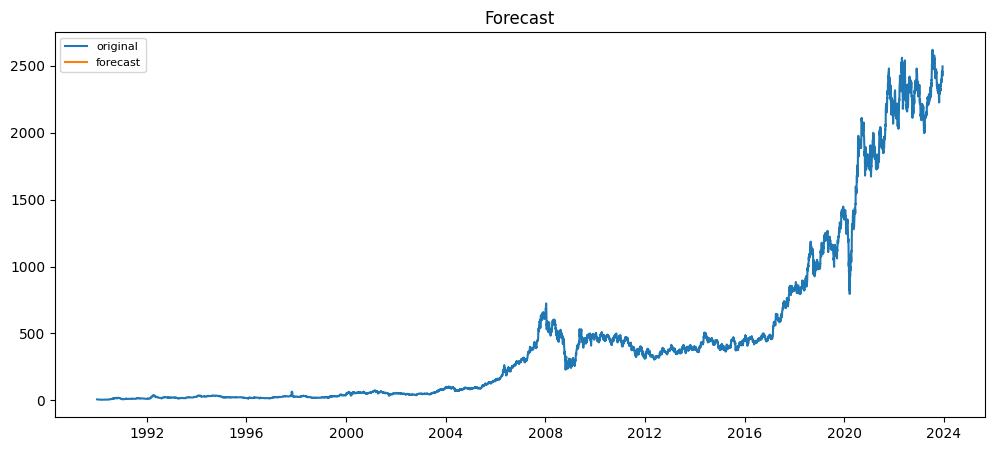

In [69]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(stock_data, label='original')

plt.plot(future_df['Price'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [70]:
future_df

,Price
2023-12-16,NaN
2023-12-17,NaN
2023-12-18,NaN
2023-12-19,NaN
2023-12-20,NaN
2023-12-21,NaN
2023-12-22,NaN
2023-12-23,NaN
2023-12-24,NaN
2023-12-25,NaN


In [65]:
# # Assuming 'stock_data' is your DataFrame with the 'Price' column as the index
# stock_data.index = pd.to_datetime(stock_data.index)

# # Generate future dates within the specified range
# start_date = pd.to_datetime('2023-12-16')
# end_date = pd.to_datetime('2024-02-15')

# # Combine existing index dates with the specified range for forecasting
# all_dates = stock_data.index.union(pd.date_range(start=start_date, end=end_date, freq='D'))
# future_df = pd.DataFrame(index=all_dates, columns=stock_data.columns)

# # Perform ARIMA forecasting within the selected range if available in the dataset
# start_idx = max(stock_data.index.min(), start_date)
# end_idx = min(stock_data.index.max(), end_date)

# # Ensure the indices are within the available range in the dataset
# if start_idx <= end_idx:
#     forecast = final_arima.predict(start=start_idx, end=end_idx, dynamic=True)  # Use 'final_arima' directly for prediction

#     # Update future_df with the forecast values within the selected range
#     future_df.loc[start_idx:end_idx, 'Price'] = forecast

#     # Plotting the original data and the forecast for the selected range
#     plt.figure(figsize=(12, 5), dpi=100)
#     plt.plot(stock_data.index, stock_data['Price'], label='Original')
#     plt.plot(future_df['Price'], label='Forecast')

#     plt.title('Forecast from 2023-12-16 to 2024-02-15')
#     plt.legend(loc='upper left', fontsize=8)
#     plt.show()
# else:
#     print("Selected date range is outside the available data range. Please adjust.")
